In [1]:
# Importing required libraries
import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()

In [2]:
imb = pd.read_csv("../data/imbalance_1h.csv")

In [3]:
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

imb_2019 = pd.read_csv("../data/imbalance_1h_2019.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)
imb_2020 = pd.read_csv("../data/imbalance_1h_2020.csv", index_col=0, parse_dates=['timestamp'], date_parser=dateparse)

In [4]:
imb_2019.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


In [5]:
imb_2019.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20424 entries, 2019-01-01 00:00:00 to 2021-04-30 23:00:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   imbalance_price  20424 non-null  float64
dtypes: float64(1)
memory usage: 319.1 KB


In [6]:
#imb = imb.set_index('datetime')

In [7]:
#imb.drop(['2', 'weekday', 'date'], axis=1, inplace=True)

In [8]:
def train_test_split(df):
    n = int(len(df)*0.7)
    train, test = df.iloc[:n], df.iloc[n:]

    return train,test

In [9]:
train_2019, test_2019 = train_test_split(imb_2019)
train_2020, test_2020 = train_test_split(imb_2020)

In [10]:
print(train_2019.shape, test_2019.shape)
print(train_2020.shape, test_2020.shape)

(14296, 1) (6128, 1)
(8164, 1) (3500, 1)


In [11]:
train_2019.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


<Figure size 1008x1008 with 0 Axes>

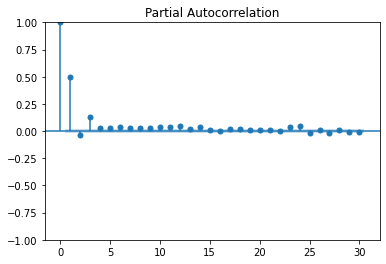

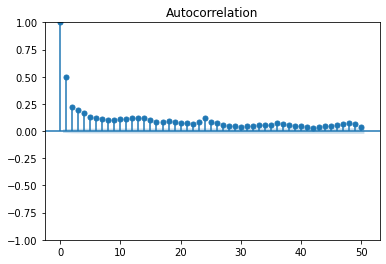

In [12]:
plt.figure(figsize=(14, 14))
pacf = plot_pacf(train_2019, lags=30, alpha=0.05)
acf = plot_acf(train_2019, lags=50, alpha=0.05)

Conclusion : AR (3), MA? (10 or 40)

In [17]:
p_range = range(1,6)
d_range = [1,2]
q_range = [9,10,11,29,30,31]

In [18]:
def best_aic(df, p_range, d_range, q_range):
    aic = []
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                model = ARIMA(df, order=order)
                model_fit = model.fit()
                aic.append([order, model_fit.aic])
                print(order, model_fit.aic)
    return aic

        

aic_stored = [ (1, 1, 9) 218438.0776477024,
(1, 1, 10) 218438.01246079954,
(1, 1, 11) 218440.0511899708,
(1, 1, 29) 218340.04531203417,
(1, 1, 30) 218338.54849014725,
(1, 1, 31) 218340.52428676168,
(1, 2, 9) 218564.85978435766,
(1, 2, 10) 218549.11981467105,
(1, 2, 11) 218444.7523995524,
(1, 2, 29) 218378.39439223066,
(1, 2, 30) 218372.16868848068,
(1, 2, 31) 218375.07940818206,
(2, 1, 9) 218441.75412751187,
(2, 1, 10) 218432.7815369026,
(2, 1, 11) 218442.93800884116,
(2, 1, 29) 218345.72706959496,
(2, 1, 30) 218338.1428312349,
(2, 1, 31) 218337.6654606091,
(2, 2, 9) 218559.46220384608,
(2, 2, 10) 218544.80879750013,
(2, 2, 11) 218535.00113799973,
(2, 2, 29) 218387.8264022952
(3, 1, 31) 218347.48071973433,]

### Best ARIMA model so far
aic = best_aic(train_2019, [2], [1], [31])

In [22]:
test_2019.iloc[1]

imbalance_price   -49.943
Name: 2020-08-18 17:00:00, dtype: float64

In [20]:
model_best = ARIMA(train_2019, order=(2,1,31))
model_best_fit = model_best.fit()
forecast_1h = model_best_fit.forecast(steps=1)
forecast_1h

2020-08-18 16:00:00    193.573248
Freq: H, dtype: float64

In [24]:
model_best_fit.aic

212790.79073691095

In [23]:
test_2020.iloc[1]

imbalance_price   -268.4625
Name: 2020-12-06 05:00:00, dtype: float64

In [21]:
model_best20 = ARIMA(train_2020, order=(2,1,31))
model_best_fit20 = model_best20.fit()
forecast_1h_20 = model_best_fit20.forecast(steps=1)
forecast_1h_20

2020-12-06 04:00:00   -229.526853
Freq: H, dtype: float64

In [25]:
model_best_fit20.aic

120686.52230650144

In [26]:
train_2019.head()

,imbalance_price
timestamp,
2019-01-01 00:00:00,-329.6045
2019-01-01 01:00:00,-283.8000
2019-01-01 02:00:00,-334.7170
2019-01-01 03:00:00,117.6665
2019-01-01 04:00:00,-323.3150


In [35]:
#for i in range(len(test_2019)):
forecasts = []
for i in range(20):
    model = ARIMA(train_2019.iloc[:-(20-i),:], order=(2,1,31))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=1)
    print(forecast)
    forecasts.append(forecast)

In [ ]:
plt.plot(imb_2019.iloc[len(train_2019)+20], label='actual')
plt.plot()

In [ ]:
# or parameters of the model (fit_intercept for Linear Regression model)
mlflow_params = {
      "p": fitted_model.params,
      "d": ,
      "q": ,
  }

In [ ]:
# logging params to mlflow
mlflow.log_params(params)
# setting tags
mlflow.set_tag("model", "ARIMA")
mlflow.set_tag("features", "imbalance price")
# logging metrics
mlflow.log_metric("test-" + "RMSE", rmse)
mlflow.log_metric("test-" + "R2", rsquared)
# end run
mlflow.end_run()

In [ ]:
plt.figure(figsize=(14,6))
residuals = pd.DataFrame(model_fit.resid)
plt.plot(residuals, label='residuals')
#plt.plot(train_2019, label= 'original', alpha=0.5)
plt.legend()